# 3 Conditional Variational Auto-encoder

In [1]:
import os

import pyro
import pyro.distributions as D
import pyro.contrib.examples.util 
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO
from pyro.optim import Adam

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from pyro.contrib.examples.util import MNIST
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
from pyro.distributions.util import broadcast_shape


In [2]:
import matplotlib.pyplot as plt
from tqdm import trange

In [3]:
pyro.distributions.enable_validation(False)
pyro.set_rng_seed(0)

In [4]:
class CVAEMNIST(Dataset):
    def __init__(self, trans=None, train=True):
        self.original = MNIST('data/01_vae/', download=True, train=train)
        self.trans = trans 
    
    def __getitem__(self, index):
        img, digit = self.original[index]
        sample = {'original':img, 'digit':digit}
        if self.trans:
            sample = self.trans(sample)
        return sample 
    
    def __len__(self):
        return len(self.original)

In [5]:
class ToTensor:
    def __call__(self, sample):
        sample['original'] = T.ToTensor()(sample['original'])
        sample['digit'] = torch.tensor([sample['digit']])
        return sample

In [6]:
class MaskImages:
    def __init__(self, quadrants, mask=-1):
        self.num = quadrants
        self.mask = mask 
        
    def __call__(self, sample):
        tensor = sample['original'].squeeze()
        out = tensor.detach().clone()
        h, w = tensor.shape
        
        out[h // 2: , :w // 2] = self.mask 
        
        if self.num == 2:
            out[:, :w // 2] = self.mask 
        
        if self.num == 3:
            out[:h // 2, :] = self.mask 
            
        inp = tensor.clone()
        inp[out != self.mask] = self.mask 
        
        sample['input'] = inp 
        sample['output'] = out 
        
        return sample

In [7]:
def get_data(quadrants, batch_size):
    trans = T.Compose([
        ToTensor(),
        MaskImages(quadrants)
    ])
    datasets, dataloaders, datasizes = {}, {}, {}
    for mode in ['train', 'test']:
        datasets[mode] = CVAEMNIST(train=mode=='train', trans=trans)
        dataloaders[mode] = DataLoader(
            datasets[mode], shuffle=mode=='train', batch_size=batch_size)
        datasizes[mode] = len(datasets[mode])
    
    return datasets, dataloaders, datasizes

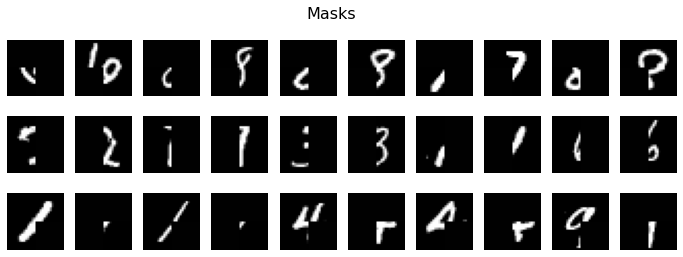

In [8]:
trans = T.ToPILImage()
plt.figure(figsize=(12, 4))
for q in range(1, 4):
    _, data, _ = get_data(q, 24)
    for samples in data['train']:
        for k in range(5):
            plt.subplot(3, 10, (q-1)*10 + 2*k+1)
            plt.imshow(trans(samples['input'][k]), cmap='gray')
            plt.axis('off')
            plt.subplot(3, 10, (q-1)*10 + 2*(k+1))
            plt.imshow(trans(samples['output'][k]), cmap='gray')
            plt.axis('off')
        break
plt.suptitle('Masks', fontsize=16)
plt.show()
plt.close()

## Baseline: Deterministic NN

In [9]:
class Baseline(nn.Module):
    def __init__(self, hidden=500):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(784, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 784),
        )
        
    def forward(self, x):
        return torch.sigmoid(self.model(x))

In [10]:
class MaskedBCELoss(nn.Module):
    def __init__(self, mask=-1):
        super().__init__()
        self.mask = mask 
        
    def forward(self, input, target):
        target = target.view(input.shape)
        loss = F.binary_cross_entropy(input, target, reduction='none')
        loss[target == self.mask] = 0
        return loss.sum()

In [11]:
def evaluate(model, dataloader):
    trans = T.ToPILImage()
    
    
    samples = iter(dataloader).next()
    inp = samples['input'].reshape(-1, 784)
    with torch.no_grad():
        out = model(inp)
    
    rec = inp.clone().numpy()
    rec = np.where(rec == -1, out.numpy(), rec)
    orig = samples['original']
    
    inp = torch.as_tensor(inp)
    rec = torch.as_tensor(rec)
    
    
    plt.figure(figsize=(12, 4))
    for k in range(1, 11):
        plt.subplot(3, 10, k)
        plt.imshow(trans(inp[k].view(28, 28)), cmap='gray')
        plt.axis('off')
        
        plt.subplot(3, 10, 10 + k)
        plt.imshow(trans(rec[k].view(28, 28)), cmap='gray')
        plt.axis('off')
        
        plt.subplot(3, 10, 20 + k)
        plt.imshow(trans(orig[k].view(28, 28)), cmap='gray')
        plt.axis('off')
        
    plt.suptitle('Reconstruction', fontsize=16)
    plt.tight_layout()
    plt.show()
    plt.close()
    

In [12]:
def train_loop(quadrants, epochs=100, early_stop=5):
    model = Baseline()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criteria = MaskedBCELoss()
    
    best_loss = 9e9
    stop_cnt = 0
    
    _, dataloaders, _ = get_data(quadrants, 128)
    
    pbar = trange(epochs)
    
    for epoch in pbar:
        loss_ = 0
        for samples in dataloaders['train']:
            out = model(samples['input'].reshape(-1, 784))
            loss = criteria(out, samples['output'])
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        with torch.no_grad():   
            for samples in dataloaders['test']:
                out = model(samples['input'].reshape(-1, 784))
                loss_ += criteria(out, samples['output']) / 128
            
        loss_ /= len(dataloaders['test'])
        
        if loss_ > best_loss:
            stop_cnt += 1
            if stop_cnt == early_stop:
                break
        else:
            stop_cnt = 0
            best_loss = loss_
            
        pbar.set_description(f'best loss: {best_loss:.2f}, count: {stop_cnt}')
    pbar.close()
    evaluate(model, dataloaders['test'])      
    return model
            

            
            

best loss: 99.22, count: 4:  27%|██▋       | 27/100 [07:23<19:58, 16.42s/it] 


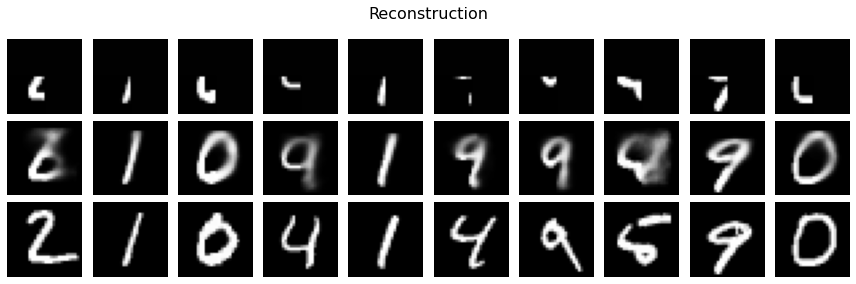

best loss: 61.04, count: 4:  27%|██▋       | 27/100 [08:21<22:34, 18.56s/it]


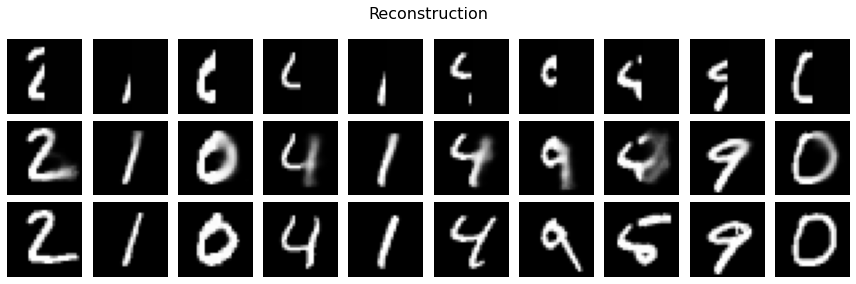

best loss: 25.21, count: 4:  20%|██        | 20/100 [06:34<26:16, 19.71s/it]


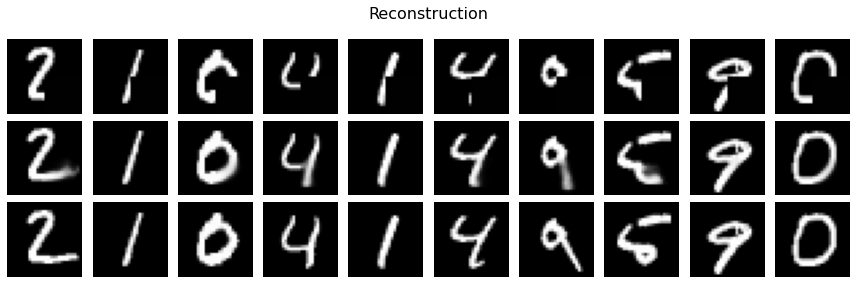

In [13]:
pretrained = {}
for q in range(1, 4):
    pretrained[q] = train_loop(q)

## Deep Conditional Generative Models for Structured Output Prediction

In [14]:
class Encoder(nn.Module):
    def __init__(self, zdim=200, hidden=500):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(784, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU()
        )
        self.loc = nn.Linear(hidden, zdim)
        self.scale = nn.Linear(hidden, zdim)
        
    def forward(self, x, y):
        xc = x.clone()
        xc[x == -1] = y[x == -1]
        xc = xc.view(-1, 784)
        hidden = self.fc(xc)
        loc = self.loc(hidden)
        scale = torch.exp(self.scale(hidden))
        return loc, scale 
    
    
class Decoder(nn.Module):
    def __init__(self, zdim=200, hidden=500):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(zdim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 784)
        )
        
    def forward(self, z):
        return torch.sigmoid(self.model(z))

In [15]:
class CVAE(nn.Module):
    def __init__(self, baseline, zdim=200, hidden=500):
        super().__init__()
        self.baseline = baseline 
        self.prior = Encoder(zdim, hidden)
        self.generator = Decoder(zdim, hidden)
        self.recognition = Encoder(zdim, hidden)
        
    def model(self, x, y=None):
        pyro.module('generation_net', self)
        x = x.view(-1, 784)
        batch_size = x.size(0)
        
        with pyro.plate('data'):
            with torch.no_grad():
                yhat = self.baseline(x).view(x.shape)
                
            prior_loc, prior_scale = self.prior(x, yhat)
            z = pyro.sample('z', D.Normal(prior_loc, prior_scale).to_event(1))
            
            loc = self.generator(z)
            
            if y is not None:
                maskloc = loc[x == -1].view(batch_size, -1)
                masky = y[x == -1].view(batch_size, -1)
                pyro.sample('y', D.Bernoulli(maskloc).to_event(1), obs=masky)
            else:
                pyro.deterministic('y', loc.detach())
                
            return loc 
        
    
    def guide(self, x, y=None):
        with pyro.plate('data'):
            if y is None:
                with torch.no_grad():
                    yhat = self.baseline(x).view(x.shape)
                loc, scale = self.prior(x, yhat)
            else:
                loc, scale = self.recognition(x, y)
            pyro.sample('z', D.Normal(loc, scale).to_event(1))

In [16]:
def train_loop(quadrants, epochs=100, early_stop=5):
    _, dataloaders, _ = get_data(quadrants, 128)
    model = CVAE(pretrained[quadrants])
    
    svi = SVI(model.model, model.guide, Adam({'lr':1e-3}), Trace_ELBO())
    
    best_loss = 9e9
    stop_cnt = 0 
    pbar = trange(epochs)
    
    for epoch in pbar:
        loss_ = 0
        for samples in dataloaders['train']:
            x, y = samples['input'], samples['output']
            x, y = x.view(-1, 784), y.view(-1, 784)
            svi.step(x, y)
            
        for samples in dataloaders['test']:
            x, y = samples['input'], samples['output']
            x, y = x.view(-1, 784), y.view(-1, 784)
            loss_ += svi.evaluate_loss(x, y)
            
        loss_ /= (len(dataloaders['test']) * 128)
        
        if loss_ < best_loss:
            stop_cnt = 0
            best_loss = loss_
        else:
            stop_cnt += 1
            if stop_cnt == early_stop:
                break 
            
        pbar.set_description(f'best loss: {best_loss:.2f}, count: {stop_cnt}')
        
    pbar.close()
    evaluate(model.model, dataloaders['test'])
    return model
            
    
    

best loss: 70.30, count: 4:  67%|██████▋   | 67/100 [45:07<22:13, 40.41s/it]  


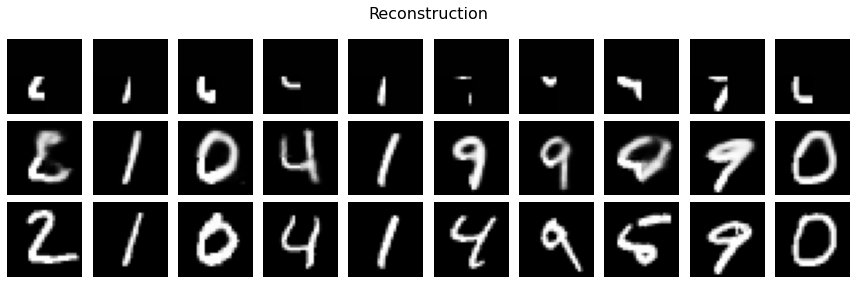

best loss: 50.00, count: 4:  58%|█████▊    | 58/100 [33:45<24:26, 34.92s/it] 


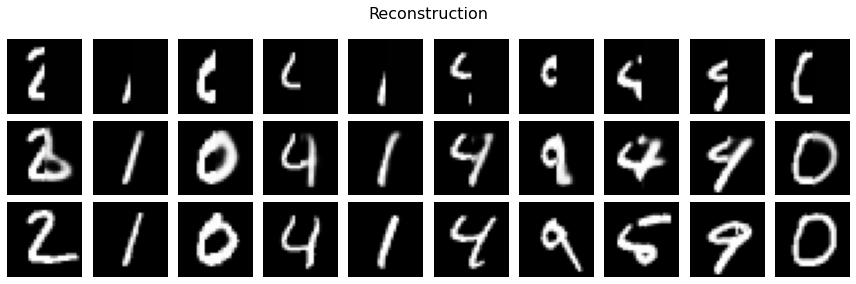

best loss: 23.36, count: 4:  69%|██████▉   | 69/100 [38:07<17:07, 33.15s/it]


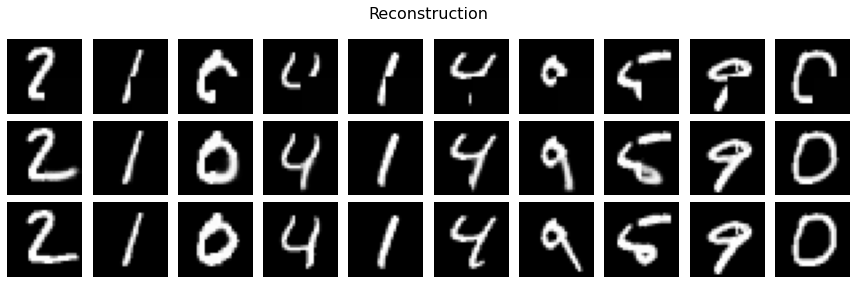

In [17]:
for q in range(1, 4):
    pyro.clear_param_store()
    train_loop(q)